In [1]:
planta = 10
print("Planta a Analizar: ", planta)

Planta a Analizar:  10


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: center; text-align: center; justify-content: center; } </style> """))

In [3]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [4]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos[53736:]

In [5]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314','GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [6]:
n_periods = 5*24
columna = columns[planta-1]
columna

'GICIS310'

In [7]:
df = datos[['hora',columna]]
df[columna] = (df[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
df = df.dropna()
df.head()

,hora,GICIS310
fecha_hora,,
2020-01-01 00:00:00,1,0.0
2020-01-01 01:00:00,2,0.0
2020-01-01 02:00:00,3,0.0
2020-01-01 03:00:00,4,0.0
2020-01-01 04:00:00,5,0.0


In [8]:
# Original Series
df2 = df.drop(['hora'], axis=1)
df2

df2_diff = df2.diff()
df2_diff_diff = df2.diff().diff()

***

In [9]:
#Seleccion de y_train y y_test
  
n = 1 #numero de dias a simular
test = (df2.iloc[-(1*24):,:])   # INFO DE TEST 
train = df2.drop(df.index[:(1*24)]) # QUITANDO TEST PARA TRAIN

predicted=136.401553, expected=4871.000000
predicted=9927.864872, expected=35284.000000
predicted=48828.629466, expected=102803.000000
predicted=120476.452686, expected=169574.000000
predicted=174867.266601, expected=167916.000000
predicted=148080.395802, expected=164215.000000
predicted=151201.116187, expected=153332.000000
predicted=135812.867941, expected=92871.000000
predicted=65810.786547, expected=52542.000000
predicted=45450.660340, expected=35075.000000
predicted=35523.475031, expected=11967.000000
predicted=9158.010634, expected=815.000000


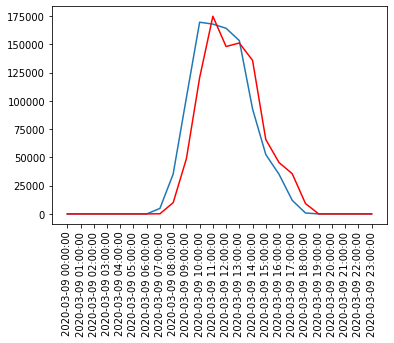

1.322895348429829

In [10]:
history = [x for x in train.values]
predictions = list()
predictions.append(0)
predictions.append(0)
predictions.append(0)
predictions.append(0)
predictions.append(0)
predictions.append(0)
predictions.append(0)
for t in range(7,19):
    model = ARIMA(history, order=(8,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.values[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
predictions.append(0)
predictions.append(0)
predictions.append(0)
predictions.append(0)
predictions.append(0)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

fvst = pd.DataFrame()
fvst['real'] = test[columna].values.flatten()
fvst['forecasts'] = predictions
fvst['error'] = 0
for i in range(len(fvst)):
    fvst['error'][i] = np.abs((fvst['forecasts'][i]- fvst['real'][i])/(fvst['real'][i]))

mea = np.mean(fvst.iloc[7:19,2])
mea

In [11]:
fvst = fvst.fillna(0)
fvst

,real,forecasts,error
0,0.0,0,0.000000
1,0.0,0,0.000000
2,0.0,0,0.000000
3,0.0,0,0.000000
4,0.0,0,0.000000
5,0.0,0,0.000000
6,0.0,0,0.000000
7,4871.0,[136.40155331405293],0.971997
8,35284.0,[9927.864872024064],0.718630
9,102803.0,[48828.62946635346],0.525027


In [12]:
fvst = fvst.fillna(0)
np.mean(fvst.error)

0.6614476742149145